# PREDICTING AMOUNT OF INSURANCE PREMIUM USING MACHINE LEARNING MODELS WITH PYSPARK

#### About the Dataset
This is data on some of the risk factors that are considered during the underwriting process of health insurance. These in turn influence premium amounts that the client will be charged.

The variables represent the following:
age : age of policyholder

sex: gender of policyholder (female=0, male=1)

bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 25 steps: average walking steps per day of policyholder

children: number of children / dependents of policyholder

smoker: smoking status of policyholder (non-smoke=0;smoker=1)

region: the residential area of policyholder in the US (northeast=0, northwest=1, southeast=2, southwest=3)

charges: individual premium paid to the insurance company

### Load Libraries

In [1]:
# Import  libraries
from pyspark.sql import SparkSession

import pandas as pd
import dataframe_image as dfi
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr, pearsonr, norm

from pyspark.sql.functions import (col, sum, datediff, to_date, countDistinct, lit, when)
from pyspark.sql.types import IntegerType

from pyspark.ml.feature import (VectorAssembler, MinMaxScaler, OneHotEncoder,StringIndexer, VectorIndexer)
from pyspark.ml import Pipeline
from pyspark.ml.tuning import (ParamGridBuilder, TrainValidationSplit)

from pyspark.ml.regression import (LinearRegression, RandomForestRegressor, GBTRegressor)

from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
# Create a SparkSession
spark = SparkSession.builder.appName('data').getOrCreate()

### Load data

In [3]:
# load the data into a spark dataframe
data = spark.read.csv('underwriting_data.csv', inferSchema=True, header=True)

In [4]:
# display the first few rows of the data
data.show()

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|
| 46|female| 33.44|       1|    no|southeast|  8240.5896|
| 37|female| 27.74|       3|    no|northwest|  7281.5056|
| 37|  male| 29.83|       2|    no|northeast|  6406.4107|
| 60|female| 25.84|       0|    no|northwest|28923.13692|
| 25|  male| 26.22|       0|    no|northeast|  2721.3208|
| 62|female| 26.29|       0|   yes|southeast| 27808.7251|
| 23|  male|  34.4|       0|    no|southwest|   1826.843|
| 56|female| 39.82|       0|    no|southeast| 11090.7178|
| 27|  male| 4

### Data Pre-processing

In [5]:
# check the shape of the loaded data
num_rows = data.count()
num_cols = len(data.columns)

# print out the shape
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

Number of rows: 1338
Number of columns: 7


In [6]:
# check the data types of the variables in the dataframe
data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



In [7]:
# check the columns 
data.columns

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

### Data Cleaning
Here we will handle any missing values if available, duplicates and also check for any inconsistencies in the data.

###### Missing values

In [8]:
# check for missing values
missing_values = data.agg(*[
    sum(col(column).isNull().cast("integer")).alias(column + "_missing") 
    for column in data.columns
])

missing_values.toPandas()

,age_missing,sex_missing,bmi_missing,children_missing,smoker_missing,region_missing,charges_missing
0,0,0,0,0,0,0,0


###### Observation:
There are no missing values in the data.

###### Check for duplicates

In [9]:
# Group by all columns and count the number of occurrences
duplicate_rows = data.groupBy(data.columns).count().filter(col("count") > 1)

# Show the duplicate rows
duplicate_rows.show()

+---+----+-----+--------+------+---------+---------+-----+
|age| sex|  bmi|children|smoker|   region|  charges|count|
+---+----+-----+--------+------+---------+---------+-----+
| 19|male|30.59|       0|    no|northwest|1639.5631|    2|
+---+----+-----+--------+------+---------+---------+-----+



In [10]:
# print out the shape before dropping duplicates
print("Number of rows before dropping duplicates:", data.count())

# Drop duplicates based on all columns
data = data.dropDuplicates()

# print out the shape after dropping duplicates
print("Number of rows after dropping duplicates:", data.count())

Number of rows before dropping duplicates: 1338
Number of rows after dropping duplicates: 1337


###### Check for outliers in the target variable

In [11]:
# Calculate quartiles and IQR
quartiles = data.approxQuantile("charges", [0.25, 0.75], 0.01)
q1 = quartiles[0]
q3 = quartiles[1]
iqr = q3 - q1

# Define the lower and upper bounds for outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter the DataFrame to find outliers
outliers = data.filter((col("charges") < lower_bound) | (col("charges") > upper_bound))

# print the number of outliers
print("Number of outliers:", outliers.count())

# Show the outliers
outliers.show()

Number of outliers: 154
+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 60|  male|  39.9|       0|   yes|southwest|  48173.361|
| 48|  male|40.565|       2|   yes|northwest|45702.02235|
| 44|female| 43.89|       2|   yes|southeast| 46200.9851|
| 43|  male|  27.8|       0|   yes|southwest| 37829.7242|
| 33|female|  33.5|       0|   yes|southwest|  37079.372|
| 57|  male| 42.13|       1|   yes|southeast| 48675.5177|
| 60|  male|  32.8|       0|   yes|southwest|52590.82939|
| 23|female| 42.75|       1|   yes|northeast| 40904.1995|
| 55|female|  26.8|       1|    no|southwest|35160.13457|
| 50|  male|  34.2|       2|   yes|southwest|  42856.838|
| 25|female|  30.2|       0|   yes|southwest|  33900.653|
| 28|  male|  36.4|       1|   yes|southwest|51194.55914|
| 36|  male| 34.43|       0|   yes|southeast| 37742.5757|
| 34|female| 30.21|       1|   yes|northwest| 43

###### Observation:
There are 154 duplicates. This shows that several policyholders were paying high premiums based on the assessed risk factors. We will just keep these values.

### Exploratory Data Analysis

###### Descriptive statistics

In [12]:
# Descriptive statistics
descriptive_stats = data.describe()

# Show the descriptive statistics
descriptive_stats.show()

+-------+------------------+------+------------------+------------------+------+---------+------------------+
|summary|               age|   sex|               bmi|          children|smoker|   region|           charges|
+-------+------------------+------+------------------+------------------+------+---------+------------------+
|  count|              1337|  1337|              1337|              1337|  1337|     1337|              1337|
|   mean|39.222139117427076|  null|30.663451757666405|1.0957367240089753|  null|     null|13279.121486655959|
| stddev|14.044332734156425|  null| 6.100468409615797|1.2055714286412178|  null|     null|12110.359656344168|
|    min|                18|female|             15.96|                 0|    no|northeast|         1121.8739|
|    max|                64|  male|             53.13|                 5|   yes|southwest|       63770.42801|
+-------+------------------+------+------------------+------------------+------+---------+------------------+



###### Data visualization

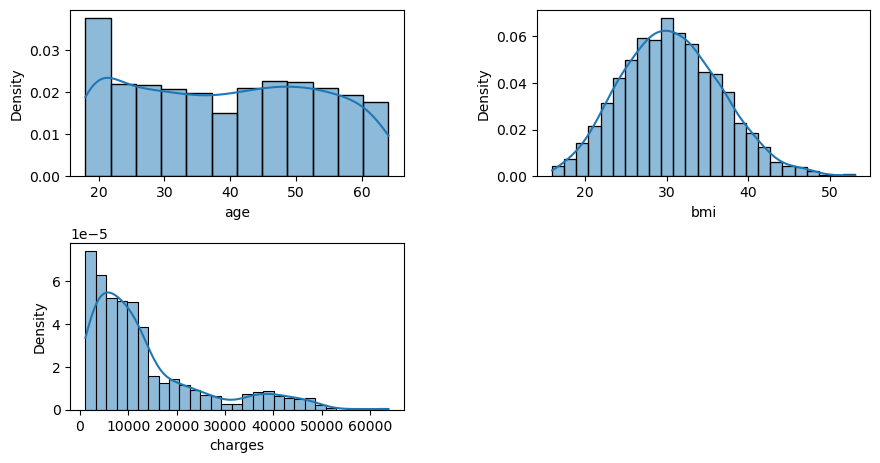

In [13]:
#Distribution plots
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

sns.histplot(data.toPandas().age, stat="density", ax=axes[0, 0], kde=True)
sns.histplot(data.toPandas().bmi, stat="density", ax=axes[0, 1], kde=True)
sns.histplot(data.toPandas().charges, stat="density", ax=axes[1, 0], kde=True)

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

fig.delaxes(axes[1, 1])
plt.show();

# save the figure
fig.savefig("distributionplots.png")

###### Observation:
`age` is approximately uniformly distributed.

The `bmi` of policyholders is normally distributed.

The amount of `charges` that the policyholders pay to the insurer is skewed to the right. There are a higher number of premiums that are below $20000.

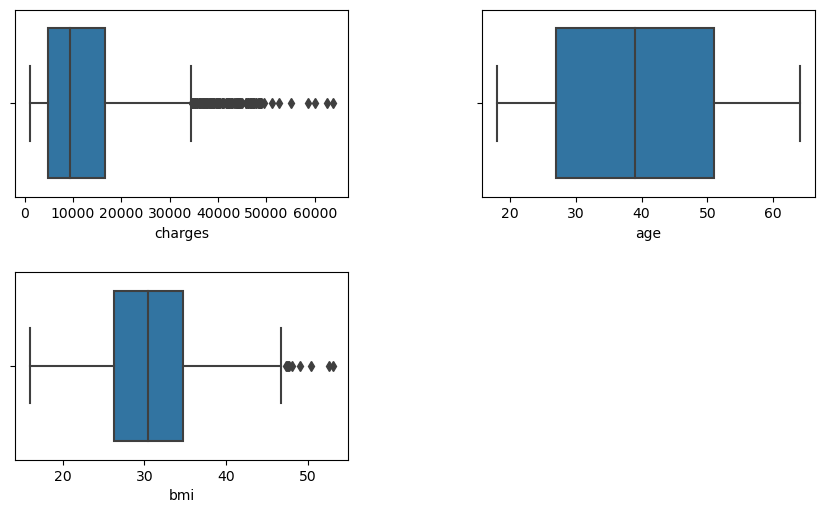

In [14]:
#Boxplot to check for outliers
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

sns.boxplot(x="charges", data=data.toPandas(), ax=axes[0, 0])
sns.boxplot(x="age", data=data.toPandas(), ax=axes[0, 1])
sns.boxplot(x="bmi", data=data.toPandas(), ax=axes[1, 0])

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.0, 
                    wspace=0.4, 
                    hspace=0.4)

fig.delaxes(axes[1, 1])
plt.show();

# save the figure
fig.savefig("boxplots.png")

###### Observation:
`charges` and `bmi` have several outliers.

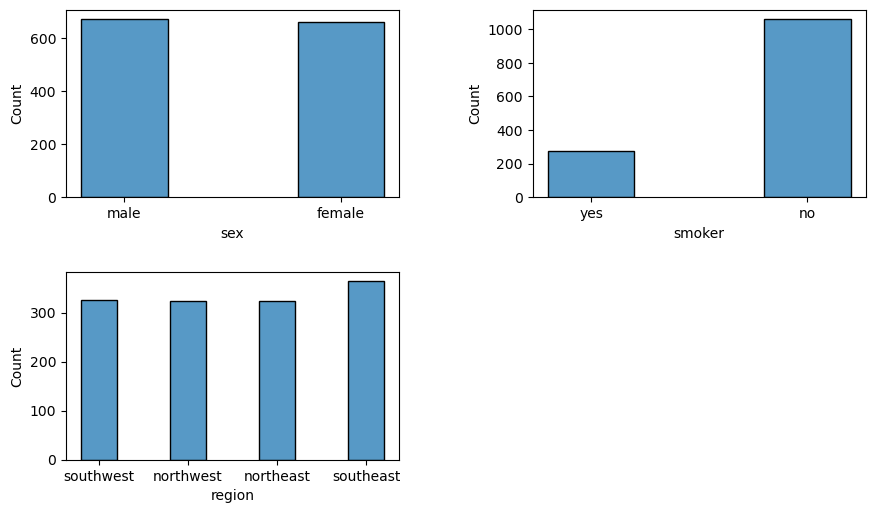

In [15]:
# How are the categorical variables distributed by numbers in the data
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

sns.histplot(x='sex', data=data.toPandas(), multiple="dodge", ax = axes[0, 0], shrink=.4)
sns.histplot(x='smoker', data=data.toPandas(), multiple="dodge", ax = axes[0, 1], shrink=.4)
sns.histplot(x='region', data=data.toPandas(), multiple="dodge", ax = axes[1, 0], shrink=.4)

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.0, 
                    wspace=0.4, 
                    hspace=0.4)

fig.delaxes(axes[1, 1])
plt.show();

# save the figure
fig.savefig("histplots.png")

###### Observation:
`males` and `females` take up insurance almost equally.

The majority of the policyholders were non-smokers.

The policyholders were evenly distributed across the 4 regions.

###### Correlation matrix

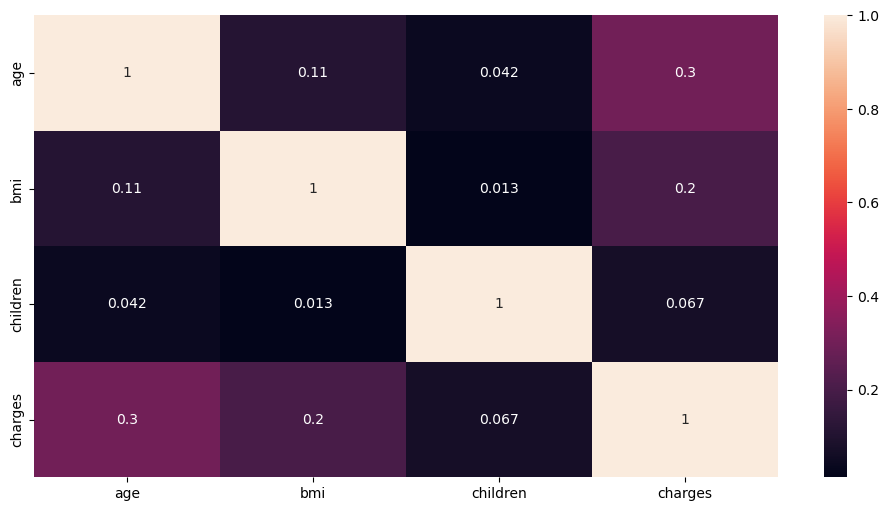

In [16]:
# Correlation matrix
fig, ax = plt.subplots(figsize=(12, 6))
correlation = data.toPandas().corr()

# plot the correlation matrix
sns.heatmap(correlation, annot=True);

# save the figure
fig.savefig("correlationmatrix.png")

###### Observation:
`age`, `bmi`, and `children` have low positive correlation with the target variable. 

There is no serious correlation between the independent features.

### Data Transformation
Some columns have the `string` data type. We need to convert them to numerical format by assigning a unique numerical index to each distinct value in a string/categorical column.

In [17]:
# count the number of unique values for every string column
unique_counts = data.select(*[
    countDistinct(col(column)).alias(column + "_unique_count") 
    for column, dtype in data.dtypes 
    if dtype == "string"
])

unique_counts.show()

+----------------+-------------------+-------------------+
|sex_unique_count|smoker_unique_count|region_unique_count|
+----------------+-------------------+-------------------+
|               2|                  2|                  4|
+----------------+-------------------+-------------------+



In [18]:
# create transformer for sex variable
sex_indexer = StringIndexer(inputCol='sex', outputCol='sexIndex')

# transform to numbers
data = sex_indexer.fit(data).transform(data)

In [19]:
# create transformer for smoker variable
smoker_indexer = StringIndexer(inputCol='smoker', outputCol='smokerIndex')

# transform to numbers
data = smoker_indexer.fit(data).transform(data)

In [20]:
# create transformer for region variable
region_indexer = StringIndexer(inputCol='region', outputCol='regionIndex')

# transform to numbers
data = region_indexer.fit(data).transform(data)

### Statistical Correlation Analysis
Let's look at the correlation of the all independent variables with our target variable using `correlation coefficient` and the `p-value` to confirm if any statistically significant correlation exists.

If the `p-value` is greater than `0.05`, then the variable is not significantly correlated with the target variable.

In [21]:
# age vs charges
cor = pearsonr(data.toPandas().age, data.toPandas().charges)

age_coef = round(cor[0], 4)
age_pv = round(cor[1], 6)
age_cor_stat = [age_coef, age_pv]

print("Correlation coefficient is: {}".format(round(cor[0], 4)))
print("Its p-value is: {}".format(round(cor[1], 6)))

Correlation coefficient is: 0.2983
Its p-value is: 0.0


In [22]:
# bmi vs charges
cor = pearsonr(data.toPandas().bmi, data.toPandas().charges)

bmi_coef = round(cor[0], 4)
bmi_pv = round(cor[1], 6)
bmi_cor_stat = [bmi_coef, bmi_pv]

print("Correlation coefficient is: {}".format(round(cor[0], 4)))
print("Its p-value is: {}".format(round(cor[1], 6)))

Correlation coefficient is: 0.1984
Its p-value is: 0.0


In [23]:
# children vs charges
cor = pearsonr(data.toPandas().children, data.toPandas().charges)

children_coef = round(cor[0], 4)
children_pv = round(cor[1], 6)
children_cor_stat = [children_coef, children_pv]

print("Correlation coefficient is: {}".format(round(cor[0], 4)))
print("Its p-value is: {}".format(round(cor[1], 6)))

Correlation coefficient is: 0.0674
Its p-value is: 0.013717


In [24]:
# sex vs charges
cor = pearsonr(data.toPandas().sexIndex, data.toPandas().charges)

sex_coef = round(cor[0], 4)
sex_pv = round(cor[1], 6)
sex_cor_stat = [sex_coef, sex_pv]

print("Correlation coefficient is: {}".format(round(cor[0], 4)))
print("Its p-value is: {}".format(round(cor[1], 6)))

Correlation coefficient is: -0.058
Its p-value is: 0.033821


In [25]:
# smoker vs charges
cor = pearsonr(data.toPandas().smokerIndex, data.toPandas().charges)

smoker_coef = round(cor[0], 4)
smoker_pv = round(cor[1], 6)
smoker_cor_stat = [smoker_coef, smoker_pv]

print("Correlation coefficient is: {}".format(round(cor[0], 4)))
print("Its p-value is: {}".format(round(cor[1], 6)))

Correlation coefficient is: 0.7872
Its p-value is: 0.0


In [26]:
# region vs charges
cor = pearsonr(data.toPandas().regionIndex, data.toPandas().charges)

region_coef = round(cor[0], 4)
region_pv = round(cor[1], 6)
region_cor_stat = [region_coef, region_pv]

print("Correlation coefficient is: {}".format(round(cor[0], 4)))
print("Its p-value is: {}".format(round(cor[1], 6)))

Correlation coefficient is: -0.0561
Its p-value is: 0.040376


In [27]:
# create a dataframe combining the correlation coefficient and p-value for all variables
features_target_corr = pd.DataFrame({
    "age": age_cor_stat,
    "sex": sex_cor_stat,
    "bmi": bmi_cor_stat,
    "children": children_cor_stat,
    "smoker": smoker_cor_stat,
    "region": region_cor_stat
},
    index = ["Correlation coefficient with insuranceclaim", "P-value"]
)

# save the dataframe as an image
dfi.export(features_target_corr, "features_target_corr.png")

features_target_corr

,age,sex,bmi,children,smoker,region
Correlation coefficient with insuranceclaim,0.2983,-0.058000,0.1984,0.067400,0.7872,-0.056100
P-value,0.0000,0.033821,0.0000,0.013717,0.0000,0.040376


###### Observation:
We can see that `age`, `bmi`, `children`, `smoker`, `sex`, and `region` all have statistically significant correlation with the target variable, `charges`.

### OneHot Encoding
OneHot Encoding converts each categorical index into a binary vector where only one element is 1 (indicating the presence of the category) and the rest are 0s.

In [28]:
# create feature transformer for sex variable
sex_encoder = OneHotEncoder(inputCol='sexIndex', outputCol='sexVec')

In [29]:
# create feature transformer for smoker variable
smoker_encoder = OneHotEncoder(inputCol='smokerIndex', outputCol='smokerVec')

In [30]:
# create feature transformer for region variable
region_encoder = OneHotEncoder(inputCol='regionIndex', outputCol='regionVec')

### Feature Selection
We select the original numerical variables and transformed variables.
These will be our features (independent variables) when building the models.

In [31]:
# Feature selection and transformation
assembler = VectorAssembler(inputCols=['age', 'bmi', 'children', 
                                       'sexVec', 'smokerVec','regionVec'],
                            outputCol='features')

### Data Normalization
Normalizing the data ensures that all features are on a similar scale, preventing any one feature from dominating the model's learning process. Moreover, it will help ensure that all features are equally considered by the regression model.  
This will lead to improved performance of the regression models.

In [32]:
# normalize the data
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

### Create a pipeline for data transformation, feature selection and data normalization
A pipeline will encapsulate the preprocessing operations mentioned above and enable us to apply the same operations to both the training and test datasets.
This makes transformation easy and helps avoid repetition.

In [33]:
# create a pipeline to transform the data
pipeline = Pipeline(stages=[sex_encoder, smoker_encoder, region_encoder,
                            assembler, scaler])

# Fit the pipeline to the insurance data
pipelineModel = pipeline.fit(data)

### Transform the data

In [34]:
# Transform the training dataset
data = pipelineModel.transform(data)

### Model Building
- We will build 3 different models and select the model that is more accurate in forecasting the premium.

##### Model Evaluation
I will use two metrics to evaluate the performance of the models:
1. R-squared (coefficient of determination)
- R-squared measures the proportion of the variance in the target variable that is explained by the regression model. Higher values of R-squared indicate a better fit.
2. Root Mean Squared Error (RMSE)
- The RMSE computes the average magnitude of the residuals (the difference between expected and actual values). Lower values indicate greater performance, and it gives a broad indication of how accurately the model can predict the future.

##### Split the data into training set and test set

In [35]:
# Split the data into training and test sets
trainData, testData = data.randomSplit([0.8, 0.2], seed=42)

###### Modeling

###### 1. Linear Regression Model

In [36]:
# instantiate linear regression model
lr = LinearRegression(featuresCol="scaledFeatures", labelCol="charges")
    
# Train the model
lrModel = lr.fit(trainData)

In [37]:
# evaluate the model
RMSEevaluator = RegressionEvaluator(labelCol="charges", predictionCol="prediction", metricName="rmse")
R2evaluator = RegressionEvaluator(labelCol="charges", predictionCol="prediction", metricName="r2")

# make predictions using the test set
lrPredictions = lrModel.transform(testData)
lrRMSE = RMSEevaluator.evaluate(lrPredictions)
lrR2 = R2evaluator.evaluate(lrPredictions)

# Print the model's RMSE and R2
print("LR Model RMSE:", lrRMSE)
print("LR Model R2:", lrR2)

LR Model RMSE: 6106.6511423430675
LR Model R2: 0.744235833453984


###### Observation:
The model is fairly good in predicting premium.

###### 2. Random Forest Regression Model

In [38]:
# instantiate random forest regression model
rf = RandomForestRegressor(featuresCol="scaledFeatures", labelCol="charges")

# do hyperparameter tuning
rfTvs = TrainValidationSplit(
        estimator=rf,
        estimatorParamMaps=ParamGridBuilder().addGrid(RandomForestRegressor.numTrees, list(range(10, 60, 10))).build(), # number of trees
        evaluator=RegressionEvaluator(labelCol="charges", predictionCol="prediction", metricName="rmse"), # use rmse
        trainRatio=0.8
    )
    
# Train the model
rfModel = rfTvs.fit(trainData)

In [39]:
# evaluate the model
RMSEevaluator = RegressionEvaluator(labelCol="charges", predictionCol="prediction", metricName="rmse")
R2evaluator = RegressionEvaluator(labelCol="charges", predictionCol="prediction", metricName="r2")

# make predictions using the test set
rfPredictions = rfModel.transform(testData)
rfRMSE = RMSEevaluator.evaluate(rfPredictions)
rfR2 = R2evaluator.evaluate(rfPredictions)

# Print the model's RMSE and R2
print("RF Model RMSE:", rfRMSE)
print("RF Model R2:", rfR2)

RF Model RMSE: 5131.296955398069
RF Model R2: 0.819412463171946


###### Observation:
The model is quite good at forecasting the premium charged those taking up insurance.

###### 3. Gradient Boosted Trees Model

In [40]:
# instantiate GBT model
gbt = GBTRegressor(featuresCol="scaledFeatures", labelCol="charges")

# do hyperparameter tuning
gbtTvs = TrainValidationSplit(
        estimator=gbt,
        estimatorParamMaps=ParamGridBuilder().addGrid(GBTRegressor.maxDepth, [5, 10, 15, 20]).build(), # maximum depth
        evaluator=RegressionEvaluator(labelCol="charges", predictionCol="prediction", metricName="rmse"), # use rmse
        trainRatio=0.8
    )

# Train the model
gbtModel = gbtTvs.fit(trainData)

In [41]:
# evaluate the model
RMSEevaluator = RegressionEvaluator(labelCol="charges", predictionCol="prediction", metricName="rmse")
R2evaluator = RegressionEvaluator(labelCol="charges", predictionCol="prediction", metricName="r2")

# make predictions using the test set
gbtPredictions = gbtModel.transform(testData)
gbtRMSE = RMSEevaluator.evaluate(gbtPredictions)
gbtR2 = R2evaluator.evaluate(gbtPredictions)

# Print the model's RMSE and R2
print("GBT Model RMSE:", gbtRMSE)
print("GBT Model R2:", gbtR2)

GBT Model RMSE: 4829.812207198568
GBT Model R2: 0.8400095843069892


###### Observation
The model is very good at predicting the premiums. The predictions are quite accurate.

In [45]:
#Dataframe of evaluation metrics for all the models
evaluation_metrics_df = pd.DataFrame(
    {
    'Linear Regression': [lrRMSE, lrR2],
    'Random Forest': [rfRMSE, rfR2],
    'Gradient Boosting Trees': [gbtRMSE, gbtR2]
    },
    index = ['Root Mean Squared Error', 'R-squared']
)

#Save it as a table
dfi.export(evaluation_metrics_df, "summary_evaluation_metrics.png")

evaluation_metrics_df

,Linear Regression,Random Forest,Gradient Boosting Trees
Root Mean Squared Error,6106.651142,5131.296955,4829.812207
R-squared,0.744236,0.819412,0.840010


### Best Model Selection
- The `Gradient Boosted Trees` model has the lowest RMSE of `4829.8122` followed by the Random Forest model and lastly the Linear Regression model. This indicates that the Gradient Boosted Trees Model is quite accurate in predicting the premiums.
- The `Gradient Boosted Trees` model has the highest coefficient of determination of `84.00%` followed by the Random Forest model and lastly the Linear Regression model. This indicates that the Gradient Boosted Trees Model fits the data well.
- Based on the Root Mean Squared Error and R-squared, the `Gradient Boosted Trees` model is the best fit model in predicting the `premium amounts` charged those willing to take up insurance based on `age`, `bmi`, `number of children`, `sex`, `smoker_status`, and `region`.